###Libraries


In [1]:
import numpy as np
import torch    
import torch.nn as nn
import copy
import torch.nn.functional as f
import torch.nn.utils.prune as prune
from torchvision import datasets, transforms

import torch.optim as opt
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###Tensor train layer


In [2]:
# TT_layer in Pytorch
class TTLinear(nn.Module):

    def __init__(self, in_modes, out_modes, tt_ranks, bias=True):
        super().__init__()
        self.in_modes = in_modes
        self.out_modes = out_modes
        self.tt_ranks = tt_ranks
        self.bias = bias
        self.dimension = in_modes.size
        self.full_biases = torch.nn.Parameter(torch.randn(np.prod(out_modes)))
        self.cores = nn.ParameterList([torch.nn.Parameter(torch.randn(self.in_modes[i], 
                                                                     self.tt_ranks[i],
                                                                     self.tt_ranks[i + 1], 
                                                                     self.out_modes[i]))
                                                                     for i in range(self.dimension)])
        
        self.core0 = self.cores[0]
        self.core1 = self.cores[1]
        self.core2 = self.cores[2]
        self.core3 = self.cores[3]
        self.core4 = self.cores[4]



                                                                     
        self.SetParameters()

    def SetParameters(self):
        nn.init.kaiming_uniform_(self.core0 , a=np.sqrt(self.dimension))
        nn.init.kaiming_uniform_(self.core1 , a=np.sqrt(self.dimension))
        nn.init.kaiming_uniform_(self.core2 , a=np.sqrt(self.dimension))
        nn.init.kaiming_uniform_(self.core3 , a=np.sqrt(self.dimension))
        nn.init.kaiming_uniform_(self.core4 , a=np.sqrt(self.dimension))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.cores[0])
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.full_biases, -bound, bound)

    def forward(self, input):
        #print(input.shape)
        input_reshape = torch.reshape(input, tuple(np.append([-1], self.in_modes)))
        #print(input.shape)
        input_reshape = input_reshape.to(device)
        output = torch.einsum("nabcde,ahiv,bijw,cjkx,dkly,elmz", input_reshape, self.core0,
                                                                                self.core1, 
                                                                                self.core2, 
                                                                                self.core3, 
                                                                                self.core4)
        
        output = torch.reshape(output, (-1, np.prod(self.out_modes)))
        #print(output.shape)
        if self.bias:
          #print(output.shape)
          output = torch.add(output, self.full_biases, alpha=1)
        output = output.to(device)
        return output
        

In [3]:
def check_inference_time(model, y_test):
  model.eval()
  count = 0
  with torch.no_grad():
    start = time.time()
    for x_batch, _ in y_test:
        count += len(x_batch)
        x_batch = x_batch.to(device)
        y_hat = model(x_batch)
    finish = time.time()
  return finish-start

#MNIST

## Pruning-mnist

In [4]:
def Total_Parameters(model):
    total_params= 0
    for name, parameter in model.named_parameters():
        if parameter.requires_grad == 0: continue
        params = parameter.numel()
        total_params += params
    print(f"count of traianble parameters: {total_params}")
    return total_params

class TT_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcl1 = TTLinear(np.array([2, 2, 7, 4, 7]),
                                      np.array([8, 16, 8, 16, 8]),
                                      np.array([1, 4, 4, 4, 4, 1]))
        
       
        self.fcl2 = TTLinear(np.array([8, 16, 8, 16, 8]),
                                      np.array([5, 2, 1, 1, 1]),
                                      np.array([1, 4, 4, 4, 4, 1]))
        
        
        self.bn1 = nn.BatchNorm1d(131072)
        self.bn2 = nn.BatchNorm1d(10)

        
    def forward(self, X):
        X = self.fcl1(X)
        X = f.relu(self.bn1(X))
        X = self.fcl2(X)
        X = f.relu(self.bn2(X))
        return f.log_softmax(X, dim=1)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcl1 = nn.Linear(28 * 28, 131072)
        self.fcl2 = nn.Linear(131072, 10)

        self.bn1 = nn.BatchNorm1d(131072)
        self.bn2 = nn.BatchNorm1d(10)

  

        self.prune1 = prune.l1_unstructured(self.fcl1,
                                            'weight',
                                            amount=0.995)



    def forward(self, X):
        X = X.reshape(-1, 28*28)
        X = self.fcl1(X)
        X = f.relu(self.bn1(X))
        X = self.fcl2(X)
        X = f.relu(self.bn2(X))
        self.prune1
        
        return f.log_softmax(X, dim=1)


def model_train(model, X, y, losses, ar_epochs, accs, l_c, criterion, optimizer, scheduler, epochs=25):
    start = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_accuracy = .0
    test_accuracy = []
    train_loss = []
    test_loss = []

    for epoch in range(epochs):
        print('-' * 48)
        print(f"epoch_num {epoch} / {epochs - 1}")

        for model_mode in ['train', 'test']:
            if model_mode == 'train':
                model.train()
            else:
                model.eval()
            
            loss = .0
            correct = 0
            current_dataset = X if model_mode == 'train' else y
            
            for inputs, labels in current_dataset:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(model_mode == 'train'):
                    inputs = inputs.cpu().reshape(-1, 28*28)
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    global_loss = criterion(outputs, labels)
                    #print("!!!!!!!!!!!!" , global_loss)

                    if model_mode == 'train':
                        global_loss.backward() 
                        optimizer.step()
                        #print("!!!!")

                loss += global_loss.item() * float(inputs.size(0))
                correct += torch.sum(predictions == labels.data)

            if model_mode == 'train' and scheduler != None:
                  scheduler.step()

            epoch_loss = loss / len(current_dataset)
            epoch_accuracy = correct.double() / len(current_dataset)




            current_loss = train_loss if model_mode == 'train' else test_loss
            current_loss += [epoch_loss]
           
            if l_c == 0 and model_mode == 'train':   
                losses[l_c].append(epoch_loss)
                accs[l_c].append(epoch_accuracy.cpu())
                ar_epochs[l_c].append(epoch)
            elif l_c == 0 and model_mode == 'test':
                losses[l_c + 1].append(epoch_loss)
                accs[l_c + 1].append(epoch_accuracy.cpu())
                ar_epochs[l_c + 1].append(epoch)
            elif l_c == 1 and model_mode == 'train':   
                losses[l_c + 1].append(epoch_loss)
                accs[l_c + 1].append(epoch_accuracy.cpu())
                ar_epochs[l_c + 1].append(epoch)
            elif l_c == 1 and model_mode == 'test':
                losses[l_c + 2].append(epoch_loss)
                accs[l_c + 2].append(epoch_accuracy.cpu())
                ar_epochs[l_c + 2].append(epoch)

            

            print(f"{model_mode} Loss: {epoch_loss} Accuracy: {epoch_accuracy}")

            if model_mode == 'test' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model = copy.deepcopy((model.state_dict()))

    finish = time.time() - start

    print(f"Training complete. Time spent: {finish} s")
    print(f"Best validation accuracy {best_accuracy}")

    model.state_dict(best_model)
    return model

In [ ]:
def Total_Parameters(model):
    total_params= 0
    for name, parameter in model.named_parameters():
        if parameter.requires_grad == 0: continue
        params = parameter.numel()
        total_params += params
    print(f"count of traianble parameters: {total_params}")
    return total_params

class TT_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcl1 = TTLinear(np.array([2, 2, 7, 4, 7]),
                                      np.array([8, 16, 8, 16, 8]),
                                      np.array([1, 4, 4, 4, 4, 1]))
        
       
        self.fcl2 = TTLinear(np.array([8, 16, 8, 16, 8]),
                                      np.array([5, 2, 1, 1, 1]),
                                      np.array([1, 4, 4, 4, 4, 1]))
        
        
        self.bn1 = nn.BatchNorm1d(131072)
        self.bn2 = nn.BatchNorm1d(10)

        
    def forward(self, X):
        X = self.fcl1(X)
        X = f.relu(self.bn1(X))
        X = self.fcl2(X)
        X = f.relu(self.bn2(X))
        return f.log_softmax(X, dim=1)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcl1 = nn.Linear(28 * 28, 131072)
        self.fcl2 = nn.Linear(131072, 10)

        self.bn1 = nn.BatchNorm1d(131072)
        self.bn2 = nn.BatchNorm1d(10)

        self.dropout = nn.Dropout(0.2)


    def forward(self, X):
        X = X.reshape(-1, 28*28)
        X = self.dropout(self.fcl1(X))
        X = f.relu(self.bn1(X))
        X = self.fcl2(X)
        X = f.relu(self.bn2(X))
        
        return f.log_softmax(X, dim=1)


def model_train(model, X, y, losses, ar_epochs, accs,  l_c, criterion, optimizer, scheduler, epochs=25):
    start = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_accuracy = .0
    test_accuracy = []
    train_loss = []
    test_loss = []

    for epoch in range(epochs):
        print('-' * 48)
        print(f"epoch_num {epoch} / {epochs - 1}")

        for model_mode in ['train', 'test']:
            if model_mode == 'train':
                model.train()
            else:
                model.eval()
            
            loss = .0
            correct = 0
            current_dataset = X if model_mode == 'train' else y
            
            for inputs, labels in current_dataset:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(model_mode == 'train'):
                    inputs = inputs.cpu().reshape(-1, 28*28)
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    global_loss = criterion(outputs, labels)
                    #print("!!!!!!!!!!!!" , global_loss)

                    if model_mode == 'train':
                        global_loss.backward() 
                        optimizer.step()
                        #print("!!!!")

                loss += global_loss.item() * float(inputs.size(0))
                correct += torch.sum(predictions == labels.data)

            if model_mode == 'train' and scheduler != None:
                  scheduler.step()

            epoch_loss = loss / len(current_dataset)
            epoch_accuracy = correct.double() / len(current_dataset)




            current_loss = train_loss if model_mode == 'train' else test_loss
            current_loss += [epoch_loss]
           
            if l_c == 0 and model_mode == 'train':   
                losses[l_c].append(epoch_loss)
                accs[l_c].append(epoch_accuracy.cpu())
                ar_epochs[l_c].append(epoch)
            elif l_c == 0 and model_mode == 'test':
                losses[l_c + 1].append(epoch_loss)
                accs[l_c + 1].append(epoch_accuracy.cpu())
                ar_epochs[l_c + 1].append(epoch)
            elif l_c == 1 and model_mode == 'train':   
                losses[l_c + 1].append(epoch_loss)
                accs[l_c + 1].append(epoch_accuracy.cpu())
                ar_epochs[l_c + 1].append(epoch)
            elif l_c == 1 and model_mode == 'test':
                losses[l_c + 2].append(epoch_loss)
                accs[l_c + 2].append(epoch_accuracy.cpu())
                ar_epochs[l_c + 2].append(epoch)

            

            print(f"{model_mode} Loss: {epoch_loss} Accuracy: {epoch_accuracy}")

            if model_mode == 'test' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model = copy.deepcopy((model.state_dict()))

    finish = time.time() - start

    print(f"Training complete. Time spent: {finish} s")
    print(f"Best validation accuracy {best_accuracy}")

    model.state_dict(best_model)
    return model

## Train-mnist

In [ ]:
train = datasets.MNIST('', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST('', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

X_train_mnist = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
y_test_mnist = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True)

In [6]:
losses = [[],[],[],[]]
ar_epochs = [[], [],[],[]]
accs = [[], [], [], []]

In [7]:
#TT_net

tt_model = TT_Net()
Total_Parameters(tt_model)
tt_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(tt_model.parameters(), lr=0.1, momentum=0.8)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
model = model_train(tt_model, X_train_mnist, y_test_mnist, losses, ar_epochs, accs,  0, criterion, optimizer, lr_scheduler, epochs=30)

count of traianble parameters: 397054
------------------------------------------------
epoch_num 0 / 29
train Loss: 24.305354598288734 Accuracy: 93.74166666666667
test Loss: 13.485691174864769 Accuracy: 95.92
------------------------------------------------
epoch_num 1 / 29
train Loss: 11.30173344258219 Accuracy: 96.78833333333334
test Loss: 10.125972408801317 Accuracy: 96.72
------------------------------------------------
epoch_num 2 / 29
train Loss: 9.57055342476815 Accuracy: 97.17666666666668
test Loss: 8.010448040440679 Accuracy: 97.65
------------------------------------------------
epoch_num 3 / 29
train Loss: 8.397979685260603 Accuracy: 97.48
test Loss: 6.4197011962533 Accuracy: 97.9
------------------------------------------------
epoch_num 4 / 29
train Loss: 7.779497564615061 Accuracy: 97.64833333333334
test Loss: 5.6866062032058835 Accuracy: 98.33
------------------------------------------------
epoch_num 5 / 29
train Loss: 6.975406504313772 Accuracy: 97.885
test Loss: 6.181

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1802: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [8]:
#Usualnet
model = Net()
Total_Parameters(model)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.8)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
model = model_train(model, X_train_mnist, y_test_mnist, losses, ar_epochs, accs, 1,  criterion, optimizer, lr_scheduler, epochs=30)

count of traianble parameters: 104464414
------------------------------------------------
epoch_num 0 / 29
train Loss: 61.699217011531196 Accuracy: 81.26833333333335
test Loss: 34.294542744755745 Accuracy: 90.22
------------------------------------------------
epoch_num 1 / 29
train Loss: 34.92557024707397 Accuracy: 89.80333333333334
test Loss: 26.84192119538784 Accuracy: 92.39
------------------------------------------------
epoch_num 2 / 29
train Loss: 28.453386809676886 Accuracy: 91.665
test Loss: 22.536523066461086 Accuracy: 93.54
------------------------------------------------
epoch_num 3 / 29
train Loss: 23.608901154249907 Accuracy: 93.20500000000001
test Loss: 19.103210348635912 Accuracy: 94.66
------------------------------------------------
epoch_num 4 / 29
train Loss: 19.89151995194455 Accuracy: 94.35333333333334
test Loss: 16.964443784207106 Accuracy: 95.32000000000001
------------------------------------------------
epoch_num 5 / 29
train Loss: 17.21788010932505 Accuracy: 

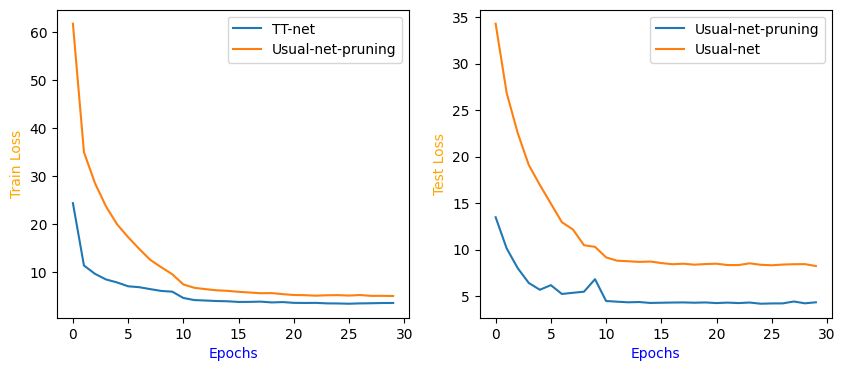

In [9]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10, 4))

ax1.plot(ar_epochs[0], losses[0], label='TT-net')
ax1.plot(ar_epochs[2], losses[2],  label='Usual-net-pruning')
ax1.set_xlabel("Epochs", fontsize=10, color='blue')
ax1.set_ylabel("Train Loss", fontsize=10, color='orange')

ax2.plot(ar_epochs[1], losses[1],  label='Usual-net-pruning')
ax2.plot(ar_epochs[3], losses[3], label='Usual-net')
ax2.set_xlabel("Epochs", fontsize=10, color='blue') 
ax2.set_ylabel("Test Loss", fontsize=10, color='orange')


ax1.legend()
ax2.legend()

plt.show()

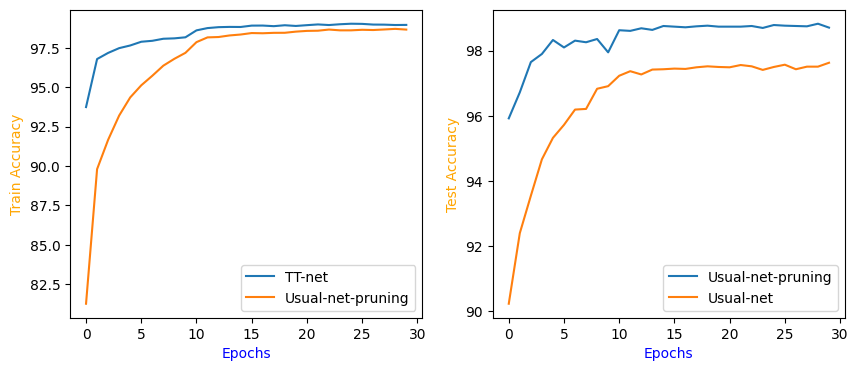

In [10]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10, 4))

ax1.plot(ar_epochs[0], accs[0], label='TT-net')
ax1.plot(ar_epochs[2], accs[2],  label='Usual-net-pruning')
ax1.set_xlabel("Epochs", fontsize=10, color='blue')
ax1.set_ylabel("Train Accuracy", fontsize=10, color='orange')

ax2.plot(ar_epochs[1], accs[1],  label='Usual-net-pruning')
ax2.plot(ar_epochs[3], accs[3], label='Usual-net')
ax2.set_xlabel("Epochs", fontsize=10, color='blue') 
ax2.set_ylabel("Test Accuracy", fontsize=10, color='orange')


ax1.legend()
ax2.legend()

plt.show()

In [11]:
tt_time = check_inference_time(tt_model, y_test_mnist)
print(f'inference time for tt-model: {tt_time:.2f} s')
usual_prune_time = check_inference_time(model, y_test_mnist)
print(f'inference time for usual model: {usual_prune_time:.2f} s')

inference time for tt-model: 1.69 s
inference time for usual model: 1.75 s


#CIFAR-10



In [ ]:
train = datasets.CIFAR10('./datasets', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ]))
test = datasets.CIFAR10('./datasets', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))
transf = transforms.Compose([
        ])
X_train = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
y_test = torch.utils.data.DataLoader(test, batch_size=100, shuffle=False)

##Pruning

In [29]:
def Total_Parameters(model):
    total_params= 0
    for name, parameter in model.named_parameters():
        if parameter.requires_grad == 0: continue
        params = parameter.numel()
        total_params += params
    print(f"count of traianble parameters: {total_params}")
    return total_params

class TT_Net(nn.Module):
    def __init__(self):
        super().__init__()

       
        self.fcl1 = TTLinear(np.array([4, 8, 4, 8, 3]),
                                      np.array([8, 4, 8, 8, 3]),
                                      np.array([1, 5, 5, 5, 5, 1]))
        
        self.fcl2 = TTLinear(np.array([8, 4, 8, 8, 3]),
                                      np.array([8, 8, 8, 8, 1]),
                                      np.array([1, 5, 5, 5, 5, 1]))
        self.fcl3 = TTLinear(np.array([8, 8, 8, 8, 1]),
                                      np.array([4, 4, 4, 4, 4]),
                                      np.array([1, 5, 5, 5, 5, 1]))
        self.fcl4 = TTLinear(np.array([4, 4, 4, 4, 4]),
                                      np.array([4, 4, 2, 4, 4]),
                                      np.array([1, 5, 5, 5, 5, 1]))
        
        self.fcl5 = TTLinear(np.array([4, 4, 2, 4, 4]),
                                      np.array([2, 4, 2, 2, 4]),
                                      np.array([1, 5, 5, 5, 5, 1]))
  
        
        self.fcl6 = nn.Linear(128, 10)

        self.bn1 = nn.BatchNorm1d(6144)
        self.bn2 = nn.BatchNorm1d(4096)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(128)
        self.bn6 = nn.BatchNorm1d(10)

        
      

    def forward(self, X):
       
        X = f.relu(self.bn1(self.fcl1(X)))
        X = f.relu(self.bn2(self.fcl2(X)))
        X = f.relu(self.bn3(self.fcl3(X)))
        X = f.relu(self.bn4(self.fcl4(X)))
        X = f.relu(self.bn5(self.fcl5(X)))
        X = f.relu(self.bn6(self.fcl6(X)))
        return f.log_softmax(X, dim=1)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcl1 = nn.Linear(32*32*3, 6144, device=device)
        self.fcl2 = nn.Linear(6144, 4096, device=device)
        self.fcl3 = nn.Linear(4096, 1024, device=device)
        self.fcl4 = nn.Linear(1024, 512, device=device)
        self.fcl5 = nn.Linear(512, 128, device=device)
        self.fcl6 = nn.Linear(128, 10, device=device)

        self.bn1 = nn.BatchNorm1d(6144)
        self.bn2 = nn.BatchNorm1d(4096)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(128)
        self.bn6 = nn.BatchNorm1d(10)

        prune_params = ((self.fcl1, 'weight'),
                        (self.fcl2, 'weight'),
                        (self.fcl3, 'weight'),
                        (self.fcl4, 'weight'),
                        (self.fcl5, 'weight'),
                        )

        self.prune = prune.global_unstructured(prune_params,
                                               pruning_method=prune.L1Unstructured,
                                               amount=0.85)

    def forward(self, X):
        X = X.reshape(-1, 32*32*3)
        X = f.relu(self.bn1(self.fcl1(X)))
        X = f.relu(self.bn2(self.fcl2(X)))
        X = f.relu(self.bn3(self.fcl3(X)))
        X = f.relu(self.bn4(self.fcl4(X)))
        X = f.relu(self.bn5(self.fcl5(X)))
        self.prune
        X = f.relu(self.bn6(self.fcl6(X)))
        return f.log_softmax(X, dim=1)


def model_train(model, X, y, losses, ar_epochs, accs,  l_c, criterion, optimizer, scheduler, epochs=25):
    start = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_accuracy = .0
    test_accuracy = []
    train_loss = []
    test_loss = []
    im_loss = []
    #l_c = torch.Tensor(l_c, dtype='float')

    for epoch in range(epochs):
        print('-' * 48)
        print(f"epoch_num {epoch} / {epochs - 1}")

        for model_mode in ['train', 'test']:
            if model_mode == 'train':
                model.train()
            else:
                model.eval()
            
            loss = .0
            correct = 0
            current_dataset = X if model_mode == 'train' else y
            
            for inputs, labels in current_dataset:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(model_mode == 'train'):
                    inputs = inputs.cpu().reshape(-1, 32*32*3)
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    global_loss = criterion(outputs, labels)
                    #print("!!!!!!!!!!!!" , global_loss)

                    if model_mode == 'train':
                        global_loss.backward() 
                        optimizer.step()
                        #print("!!!!")

                loss += global_loss.item() * float(inputs.size(0))
                correct += torch.sum(predictions == labels.data)

            if model_mode == 'train' and scheduler != None:
                  scheduler.step()

            epoch_loss = loss / len(current_dataset)
            epoch_accuracy = correct / len(current_dataset)

            if model_mode == 'train':
              current_loss = train_loss
            else:
              current_loss = test_loss
            
            current_loss += [epoch_loss]
            if l_c == 0 and model_mode == 'train':   
                losses[l_c].append(epoch_loss)
                accs[l_c].append(epoch_accuracy.cpu())
                ar_epochs[l_c].append(epoch)
            elif l_c == 0 and model_mode == 'test':
                losses[l_c + 1].append(epoch_loss)
                accs[l_c + 1].append(epoch_accuracy.cpu())
                ar_epochs[l_c + 1].append(epoch)
            elif l_c == 1 and model_mode == 'train':   
                losses[l_c + 1].append(epoch_loss)
                accs[l_c + 1].append(epoch_accuracy.cpu())
                ar_epochs[l_c + 1].append(epoch)
            elif l_c == 1 and model_mode == 'test':
                losses[l_c + 2].append(epoch_loss)
                accs[l_c + 2].append(epoch_accuracy.cpu())
                ar_epochs[l_c + 2].append(epoch)
            
            epoch_accuracy.to(device)
            if model_mode == 'test':
                  test_accuracy += [epoch_accuracy.item()]
                  #print(test_accuracy)
            print(f"{model_mode} Loss: {epoch_loss} Accuracy: {epoch_accuracy}")

            if model_mode == 'test' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model = copy.deepcopy((model.state_dict()))
    losses += im_loss

    finish = time.time() - start

    print( f"Training complete. Time spent: {finish:.1f} s")
    print(f"Best validation accuracy {best_accuracy:.2f}")

    model.state_dict(best_model)
    return model

###1

In [15]:
def Total_Parameters(model):
    total_params= 0
    for name, parameter in model.named_parameters():
        if parameter.requires_grad == 0: continue
        params = parameter.numel()
        total_params += params
    print(f"count of traianble parameters: {total_params}")
    return total_params

class TT_Net(nn.Module):
    def __init__(self):
        super().__init__()

       
        self.fcl1 = TTLinear(np.array([4, 8, 4, 8, 3]),
                                      np.array([4, 8, 8, 8, 3]),
                                      np.array([1, 5, 5, 5, 5, 1]))
        
        self.fcl2 = TTLinear(np.array([4, 8, 8, 8, 3]),
                                      np.array([4, 8, 4, 8, 4]),
                                      np.array([1, 5, 5, 5, 5, 1]))
        self.fcl3 = TTLinear(np.array([4, 8, 4, 8, 4]),
                                      np.array([4, 4, 4, 4, 4]),
                                      np.array([1, 5, 5, 5, 5, 1]))
        self.fcl4 = TTLinear(np.array([4, 4, 4, 4, 4]),
                                      np.array([4, 4, 4, 2, 4]),
                                      np.array([1, 5, 5, 5, 5, 1]))
        
        self.fcl5 = TTLinear(np.array([4, 4, 4, 2, 4]),
                                      np.array([2, 4, 2, 4, 2]),
                                      np.array([1, 5, 5, 5, 5, 1]))
  
        
        self.fcl6 = nn.Linear(128, 10)

        self.bn1 = nn.BatchNorm1d(6144)
        self.bn2 = nn.BatchNorm1d(4096)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(512)
        self.bn6 = nn.BatchNorm1d(10)


    def forward(self, X):
       
        X = f.relu(self.bn1(self.fcl1(X)))
        X = f.relu(self.bn2(self.fcl2(X)))
        X = f.relu(self.bn3(self.fcl3(X)))
        X = f.relu(self.bn4(self.fcl4(X)))
        X = f.relu(self.bn5(self.fcl5(X)))
        X = f.relu(self.bn6(self.fcl6(X)))
        return f.log_softmax(X, dim=1)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcl1 = nn.Linear(32*32*3, 6144)
        self.fcl2 = nn.Linear(6144, 4096)
        self.fcl3 = nn.Linear(4096, 1024)
        self.fcl4 = nn.Linear(1024, 512)
        self.fcl5 = nn.Linear(512, 128)
        self.fcl6 = nn.Linear(128, 10)

        self.bn1 = nn.BatchNorm1d(6144)
        self.bn2 = nn.BatchNorm1d(4096)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(128)
        self.bn6 = nn.BatchNorm1d(10)

        self.dropout = nn.Dropout(0.95)

    def forward(self, X):
        X = self.dropout(f.relu(self.bn1(self.fcl1(X))))
        X = self.dropout(f.relu(self.bn2(self.fcl2(X))))
        X = self.dropout(f.relu(self.bn3(self.fcl3(X))))
        X = self.dropout(f.relu(self.bn4(self.fcl4(X))))
        X = self.dropout(f.relu(self.bn5(self.fcl5(X))))
        X = self.dropout(f.relu(self.bn6(self.fcl6(X))))
        return f.log_softmax(X, dim=1)

    def forward(self, X):
        X = X.reshape(-1, 32*32*3)
        X = f.relu(self.bn1(self.fcl1(X)))
        X = f.relu(self.bn2(self.fcl2(X)))
        X = f.relu(self.bn3(self.fcl3(X)))
        X = f.relu(self.bn4(self.fcl4(X)))
        X = f.relu(self.bn5(self.fcl5(X)))
        X = f.relu(self.bn6(self.fcl6(X)))
        return f.log_softmax(X, dim=1)


def model_train(model, X, y, losses, ar_epochs, accs,  l_c, criterion, optimizer, scheduler, epochs=25):
    start = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_accuracy = .0
    test_accuracy = []
    train_loss = []
    test_loss = []
    im_loss = []
    #l_c = torch.Tensor(l_c, dtype='float')

    for epoch in range(epochs):
        print('-' * 48)
        print(f"epoch_num {epoch} / {epochs - 1}")

        for model_mode in ['train', 'test']:
            if model_mode == 'train':
                model.train()
            else:
                model.eval()
            
            loss = .0
            correct = 0
            current_dataset = X if model_mode == 'train' else y
            
            for inputs, labels in current_dataset:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(model_mode == 'train'):
                    inputs = inputs.cpu().reshape(-1, 32*32*3)
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    global_loss = criterion(outputs, labels)
                    #print("!!!!!!!!!!!!" , global_loss)

                    if model_mode == 'train':
                        global_loss.backward() 
                        optimizer.step()
                        #print("!!!!")

                loss += global_loss.item() * float(inputs.size(0))
                correct += torch.sum(predictions == labels.data)

            if model_mode == 'train' and scheduler != None:
                  scheduler.step()

            epoch_loss = loss / len(current_dataset)
            epoch_accuracy = correct / len(current_dataset)

            if model_mode == 'train':
              current_loss = train_loss
            else:
              current_loss = test_loss
            
            current_loss += [epoch_loss]
            if l_c == 0 and model_mode == 'train':   
                losses[l_c].append(epoch_loss)
                accs[l_c].append(epoch_accuracy.cpu())
                ar_epochs[l_c].append(epoch)
            elif l_c == 0 and model_mode == 'test':
                losses[l_c + 1].append(epoch_loss)
                accs[l_c + 1].append(epoch_accuracy.cpu())
                ar_epochs[l_c + 1].append(epoch)
            elif l_c == 1 and model_mode == 'train':   
                losses[l_c + 1].append(epoch_loss)
                accs[l_c + 1].append(epoch_accuracy.cpu())
                ar_epochs[l_c + 1].append(epoch)
            elif l_c == 1 and model_mode == 'test':
                losses[l_c + 2].append(epoch_loss)
                accs[l_c + 2].append(epoch_accuracy.cpu())
                ar_epochs[l_c + 2].append(epoch)
            
            epoch_accuracy.to(device)
            if model_mode == 'test':
                  test_accuracy += [epoch_accuracy.item()]
                  #print(test_accuracy)
            print(f"{model_mode} Loss: {epoch_loss} Accuracy: {epoch_accuracy}")

            if model_mode == 'test' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model = copy.deepcopy((model.state_dict()))
    losses += im_loss

    finish = time.time() - start

    print( f"Training complete. Time spent: {finish:.1f} s")
    print(f"Best validation accuracy {best_accuracy:.2f}")

    model.state_dict(best_model)

    return model

##train

In [10]:
losses = [[],[],[],[]]
ar_epochs = [[], [],[],[]]
accs = [[], [], [], []]

In [25]:
tt_model = TT_Net()
Total_Parameters(tt_model)

tt_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(tt_model.parameters(), lr=0.1, momentum=0.8)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
model = model_train(tt_model, X_train, y_test, losses, ar_epochs,accs, 0, criterion, optimizer, lr_scheduler, epochs=40)

count of traianble parameters: 49322
------------------------------------------------
epoch_num 0 / 39
train Loss: 167.95931766033172 Accuracy: 40.15400314331055
test Loss: 152.52639532089233 Accuracy: 44.81999969482422
------------------------------------------------
epoch_num 1 / 39
train Loss: 140.95692641735076 Accuracy: 49.75200271606445
test Loss: 138.20779526233673 Accuracy: 50.57999801635742
------------------------------------------------
epoch_num 2 / 39
train Loss: 127.77046928405761 Accuracy: 54.5780029296875
test Loss: 127.74202287197113 Accuracy: 54.32999801635742
------------------------------------------------
epoch_num 3 / 39
train Loss: 120.75575512647629 Accuracy: 56.99200439453125
test Loss: 132.19617652893066 Accuracy: 53.119998931884766
------------------------------------------------
epoch_num 4 / 39
train Loss: 115.30000395774842 Accuracy: 58.90200424194336
test Loss: 118.83524304628372 Accuracy: 57.459999084472656
-----------------------------------------------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1802: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [42]:
accs[2] = []
accs[3] = []
losses[2] = []
losses[3] = []
ar_epochs[2] = []
ar_epochs[3] = []

In [43]:
usual_model = Net()
Total_Parameters(usual_model)
usual_model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()
optimizer = torch.optim.SGD(usual_model.parameters(), lr=0.1, momentum=0.8)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
usual_model = model_train(usual_model, X_train, y_test, losses, ar_epochs, accs, 1, criterion, optimizer, lr_scheduler, epochs=40)

count of traianble parameters: 48861342
------------------------------------------------
epoch_num 0 / 39
train Loss: 162.26581797599792 Accuracy: 42.672000885009766
test Loss: 154.05946373939514 Accuracy: 45.81999969482422
------------------------------------------------
epoch_num 1 / 39
train Loss: 136.87858889102935 Accuracy: 51.762001037597656
test Loss: 154.1640751361847 Accuracy: 46.869998931884766
------------------------------------------------
epoch_num 2 / 39
train Loss: 123.76644690036774 Accuracy: 56.18000411987305
test Loss: 136.62697851657867 Accuracy: 51.78999710083008
------------------------------------------------
epoch_num 3 / 39
train Loss: 113.60805113315583 Accuracy: 59.95000457763672
test Loss: 136.89244043827057 Accuracy: 51.459999084472656
------------------------------------------------
epoch_num 4 / 39
train Loss: 103.99343951940537 Accuracy: 63.40400314331055
test Loss: 133.72925984859467 Accuracy: 53.44999694824219
------------------------------------------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1802: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


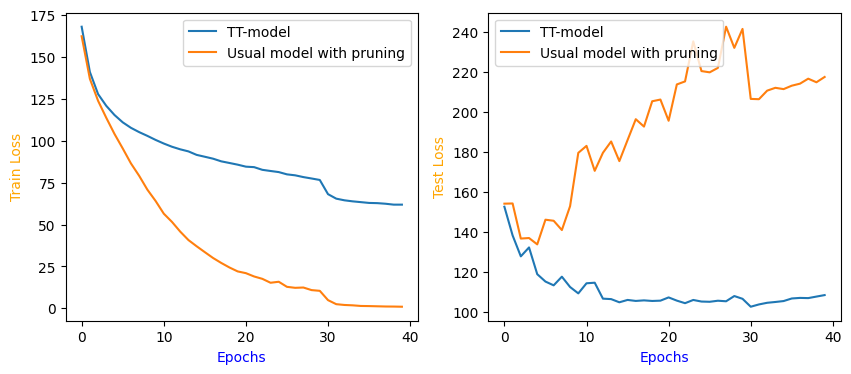

In [44]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10, 4))

ax1.plot(ar_epochs[0], losses[0], label='TT-model')
ax1.plot(ar_epochs[1], losses[2],  label='Usual model with pruning')
ax1.set_xlabel("Epochs", fontsize=10, color='blue')
ax1.set_ylabel("Train Loss", fontsize=10, color='orange')

ax2.plot(ar_epochs[2], losses[1],  label='TT-model')
ax2.plot(ar_epochs[3], losses[3], label='Usual model with pruning')
ax2.set_xlabel("Epochs", fontsize=10, color='blue') 
ax2.set_ylabel("Test Loss", fontsize=10, color='orange')


ax1.legend()
ax2.legend()

plt.show()

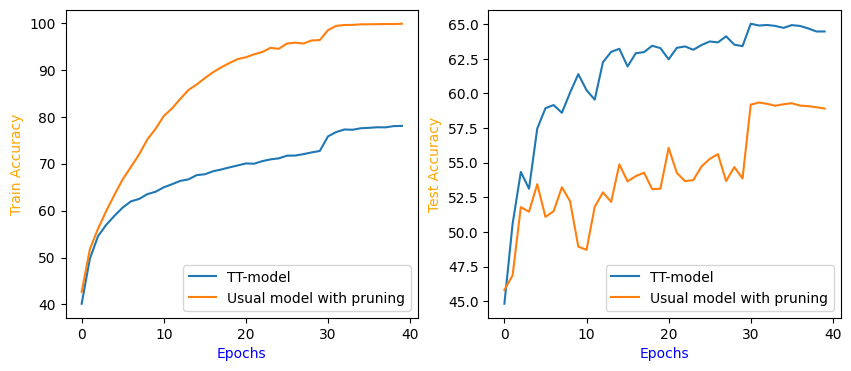

In [45]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10, 4))

ax1.plot(ar_epochs[0], accs[0], label='TT-model')
ax1.plot(ar_epochs[1], accs[2],  label='Usual model with pruning')
ax1.set_xlabel("Epochs", fontsize=10, color='blue')
ax1.set_ylabel("Train Accuracy", fontsize=10, color='orange')

ax2.plot(ar_epochs[2], accs[1],  label='TT-model')
ax2.plot(ar_epochs[3], accs[3], label='Usual model with pruning')
ax2.set_xlabel("Epochs", fontsize=10, color='blue') 
ax2.set_ylabel("Test Accuracy", fontsize=10, color='orange')


ax1.legend()
ax2.legend()

plt.show()

In [46]:
tt_time = check_inference_time(tt_model, y_test)
print(f'inference time for tt-model: {tt_time:2f} s')
#usual_prune_time = check_inference_time(usual_model, y_test)


inference time for tt-model: 2.795399 s


In [47]:
usual_prune_time = check_inference_time(usual_model, y_test)
print(f'inference time for usual model: {usual_prune_time:2f} s')

inference time for usual model: 2.082525 s
